# CS210 - Term Project: Analysis of chess data based on time


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import requests
import datetime

# Fetching The Game Data

In [71]:
username = 'pepefe'

url = f'https://lichess.org/api/games/user/{username}'

headers = {'Accept': 'application/x-chess-pgn'}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    print("Success")
else:
    print("Failed to fetch data. Status code:", response.status_code)


Success


# Parsing The Dataset

In [3]:
from io import StringIO

content = response.text

def parse_pgn(content, username='pepefe'):
    games = []
    game_info = {}
    moves_str = ""

    for line in content.split("\n"):
        if line.startswith("["):
            key = line[1:line.find(" ")]
            value = line.split('"')[1]
            if key == 'White':
                game_info['Color'] = 'White' if username in value else 'Black'
            elif key == 'WhiteElo':
                game_info['WhiteElo'] = value
            elif key == 'BlackElo':
                game_info['BlackElo'] = value
            elif key == 'Result':
                game_info['Result'] = value
            elif key == 'UTCTime':
                game_info['UTCTime'] = value
            elif key == 'TimeControl':
                game_info['GameType'] = 'Blitz' if '180' in value else 'Bullet' if '60' in value else 'Other'
            elif key == 'Date':
                game_info['Date'] = value
        elif any(char.isdigit() for char in line) and '.' in line:
            moves_str += line + " "
        elif line.strip() == "" and moves_str.strip():
            # End of a game, append game info and moves
            game_info['Game'] = moves_str.strip()
            game_info['NumberOfMoves'] = len(moves_str.strip().split('.')) - 1
            games.append(game_info)
            # Reset for the next game
            game_info = {}
            moves_str = ""

    return pd.DataFrame(games)


def interpret_result(row):
    if row['Color'] == 'White' and row['Result'] == '1-0':
        return 'Win'
    elif row['Color'] == 'Black' and row['Result'] == '0-1':
        return 'Win'
    elif row['Result'] == '1/2-1/2':
        return 'Tie'
    else:
        return 'Lose'
    
df = parse_pgn(content, username='pepefe')
df['Date'] = pd.to_datetime(df['Date'])

# Apply the function to each row to get the correct interpretation of the result
df['Result'] = df.apply(interpret_result, axis=1)


def assign_elo(row):
    if row['Color'] == 'White':
        return row['WhiteElo'], row['BlackElo']
    else:
        return row['BlackElo'], row['WhiteElo']
def categorize_time(time):
    if time is pd.NaT or time is None:
        return 'Unknown'
    if datetime.time(0, 0) <= time < datetime.time(6, 0):
        return 'Night'
    elif datetime.time(6, 0) <= time < datetime.time(12, 0):
        return 'Morning'
    elif datetime.time(12, 0) <= time < datetime.time(18, 0):
        return 'Afternoon'
    else:
        return 'Evening'


df['MyElo'], df['EnemyElo'] = zip(*df.apply(assign_elo, axis=1))

df.replace('?', 1500, inplace=True) #fixing the data


df['UTCTime'] = pd.to_datetime(df['UTCTime'], format='%H:%M:%S', errors='coerce').dt.time

df['TimeOfDay'] = df['UTCTime'].apply(categorize_time)

df['Hour'] = df['UTCTime'].apply(lambda t: t.hour)

# Filter DataFrame for Blitz and Bullet games
df_blitz = df[df['GameType'] == 'Blitz']
df_bullet = df[df['GameType'] == 'Bullet']


df.head(10)



,Date,Color,Result,UTCTime,WhiteElo,BlackElo,GameType,Game,NumberOfMoves,MyElo,EnemyElo,TimeOfDay,Hour
0,2024-01-17,White,Win,00:04:45,1312,1335,Other,1. e4 c5 2. Nf3 Nc6 3. Bb5 a6 4. Bxc6 bxc6 5. ...,19,1312,1335,Night,0
1,2024-01-16,Black,Lose,22:33:24,1500,1644,Other,1. e4 c5 2. Nf3 Nc6 3. Bc4 g6 4. O-O Nf6 5. d3...,78,1644,1500,Evening,22
2,2024-01-16,White,Win,22:32:34,1644,1500,Other,1. e3 e5 1-0,1,1644,1500,Evening,22
3,2024-01-16,Black,Lose,22:31:27,1500,1644,Other,1. e4 g5 2. Nf3 g4 3. Ng5 1-0,3,1644,1500,Evening,22
4,2024-01-16,White,Win,22:27:35,1644,1500,Other,1. e4 e5 2. Nf3 d5 3. d4 exd4 4. Nxd4 dxe4 5. ...,14,1644,1500,Evening,22
5,2024-01-16,Black,Lose,22:19:37,1500,1644,Other,1. e4 d5 2. d4 g5 3. exd5 Bg7 4. Nc3 e6 5. dxe...,31,1644,1500,Evening,22
6,2024-01-16,White,Win,22:17:06,1644,1500,Other,1. e4 e5 2. Nf3 d5 3. exd5 Nf6 4. Nc3 c6 5. Bd...,11,1644,1500,Evening,22
7,2024-01-10,White,Win,04:12:09,1306,1305,Blitz,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. c3 Nxe4 5. d...,60,1306,1305,Night,4
8,2023-12-29,White,Win,14:21:40,1299,1327,Blitz,1. e4 e6 2. Nf3 d5 3. exd5 exd5 4. d4 Nf6 5. c...,53,1299,1327,Afternoon,14
9,2023-12-29,Black,Win,14:20:18,1332,1293,Blitz,1. e4 d5 2. exd5 Nf6 3. c4 e6 4. dxe6 Bxe6 5. ...,13,1293,1332,Afternoon,14


# Blunder Calculation Algorithm

In [4]:
import chess
import chess.engine

STOCKFISH_PATH = '/Users/efeyagizkilickaya/stockfish/16/bin/stockfish'
BLUNDER_THRESHOLD = 150  # 150 centipawns (1.5 pawn)

engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)

def count_blunders(Game, pepefe_color):
    board = chess.Board()
    blunders = 0
    last_score = None
    score = None 

    for move in Game.split():
        if '.' in move:  # Skip move numbers like "1.", "2.", etc.
            continue

        try:
            info = engine.analyse(board, chess.engine.Limit(time=0.1))
            board.push_san(move)

            if last_score is not None:
                # Convert scores to centipawns for comparison
                score = info['score'].white().score(mate_score=10000)
                if board.turn == chess.WHITE:
                    score_diff = score - last_score
                else:
                    score_diff = last_score - score


                # Check if the move was a blunder
                if abs(score_diff) >= BLUNDER_THRESHOLD and board.turn == (pepefe_color == 'White'):
                    blunders += 1

            last_score = info['score'].white().score(mate_score=10000)

        except ValueError:
            continue
    return blunders

df['Blunders'] = df.apply(lambda row: count_blunders(row['Game'], row['Color']), axis=1)


# Visualization and Analysis

In [5]:
csv_file_path = 'lichess_games_parsed.csv'
df.to_csv(csv_file_path, index=False)

## Blitz Winrate vs Games Played According to Time of Day

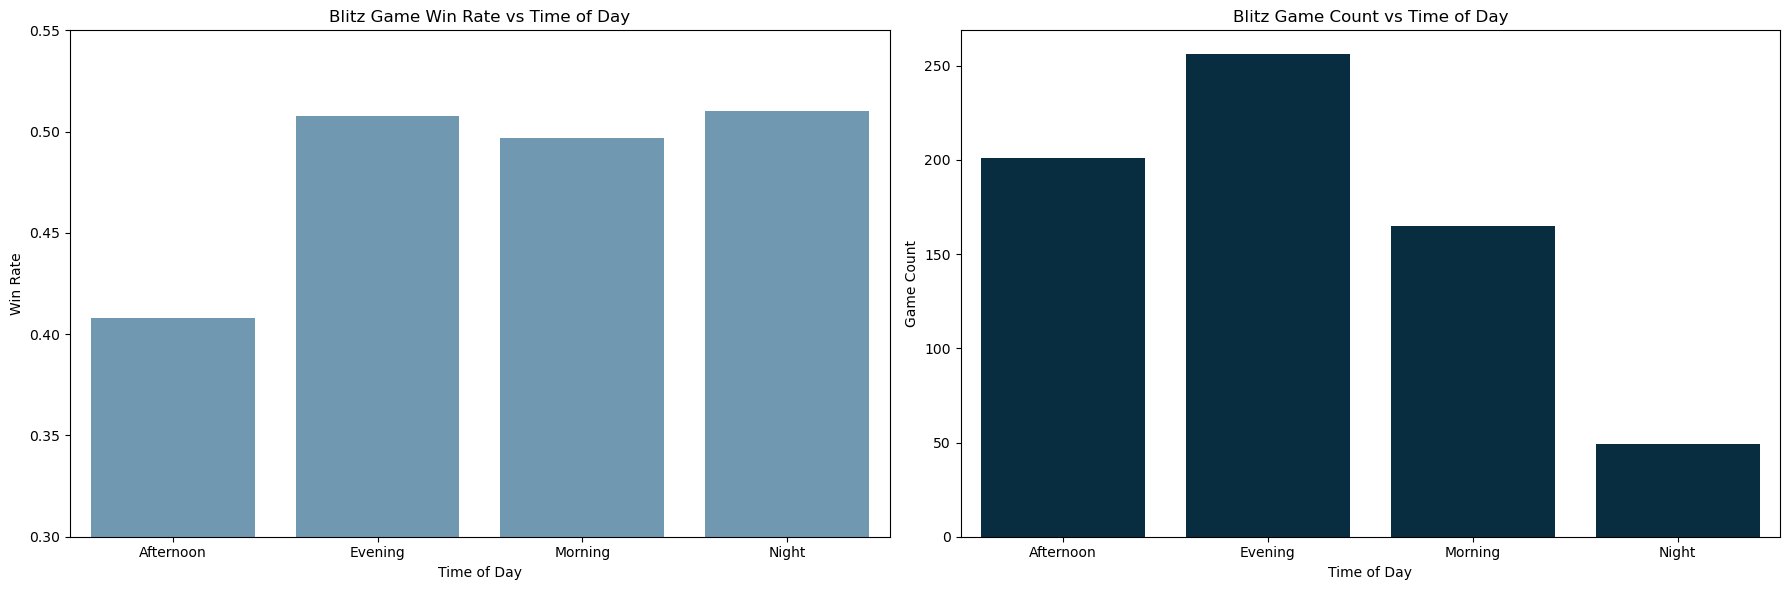

In [59]:

# Calculate win rate for Blitz games
win_rate_data_blitz = df_blitz.groupby('TimeOfDay')['Result'].apply(lambda x: (x == 'Win').sum() / len(x)).reset_index()

# Count games by TimeOfDay for Blitz games
game_count_by_time_of_day_blitz = df_blitz.groupby('TimeOfDay').size().reset_index(name='Game Count')

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot Win Rate
sns.barplot(x='TimeOfDay', y='Result', data=win_rate_data_blitz, color='#669bbc', ax=axes[0])
axes[0].set_title('Blitz Game Win Rate vs Time of Day')
axes[0].set_ylabel('Win Rate')
axes[0].set_xlabel('Time of Day')
axes[0].set_ylim([0.3, 0.55])

# Plot Game Count
sns.barplot(x='TimeOfDay', y='Game Count', data=game_count_by_time_of_day_blitz, color='#003049', ax=axes[1])
axes[1].set_title('Blitz Game Count vs Time of Day')
axes[1].set_ylabel('Game Count')
axes[1].set_xlabel('Time of Day')

plt.tight_layout()
plt.show()


## Bullet Winrate vs Games Played According to Time of Day

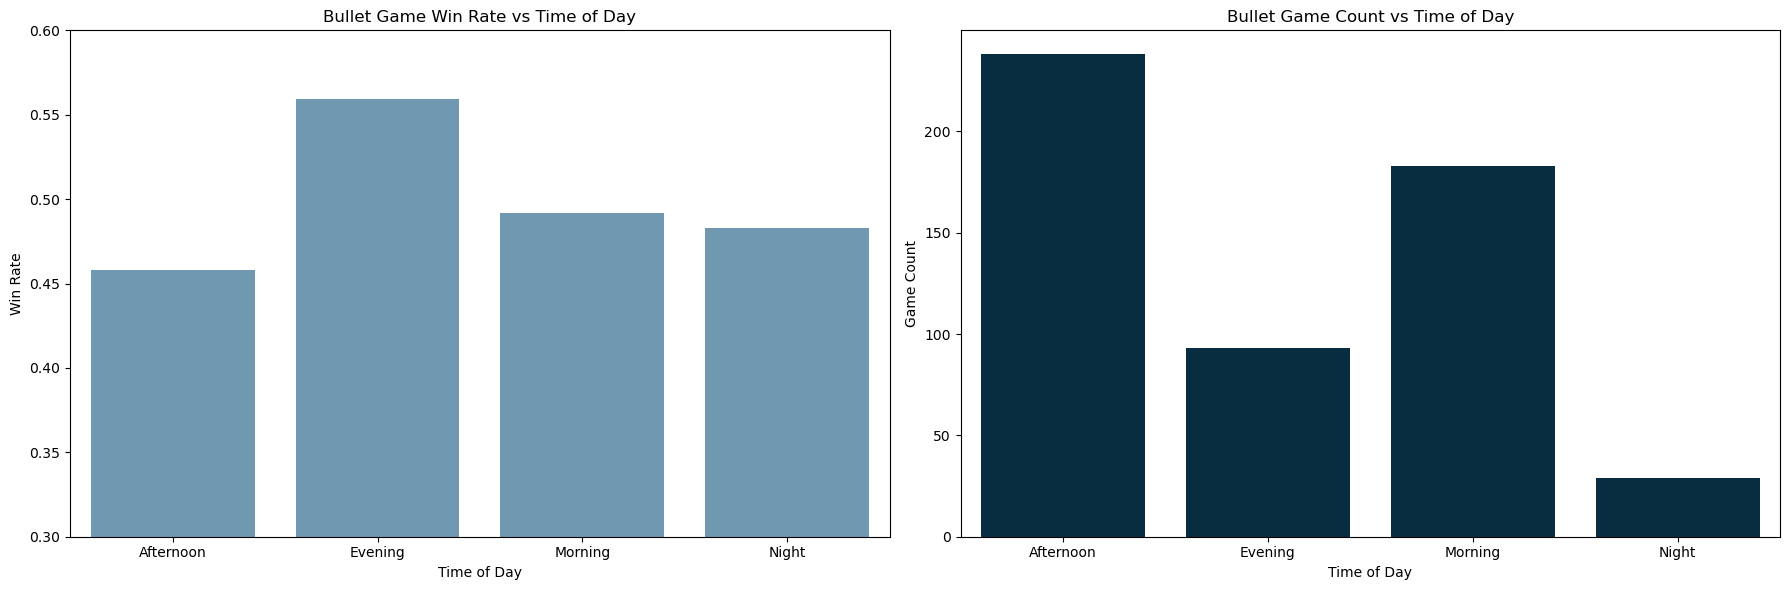

In [61]:
# Calculate win rate for Bullet games
win_rate_data_bullet = df_bullet.groupby('TimeOfDay')['Result'].apply(lambda x: (x == 'Win').sum() / len(x)).reset_index()

# Count games by TimeOfDay for Bullet games
game_count_by_time_of_day_bullet = df_bullet.groupby('TimeOfDay').size().reset_index(name='Game Count')

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot Win Rate
sns.barplot(x='TimeOfDay', y='Result', data=win_rate_data_bullet, color='#669bbc', ax=axes[0])
axes[0].set_title('Bullet Game Win Rate vs Time of Day')
axes[0].set_ylabel('Win Rate')
axes[0].set_xlabel('Time of Day')
axes[0].set_ylim([0.3, 0.6])

# Plot Game Count
sns.barplot(x='TimeOfDay', y='Game Count', data=game_count_by_time_of_day_bullet, color='#003049', ax=axes[1])
axes[1].set_title('Bullet Game Count vs Time of Day')
axes[1].set_ylabel('Game Count')
axes[1].set_xlabel('Time of Day')

plt.tight_layout()
plt.show()


## Blitz Blunders vs Games Played According to Time of Day

In [67]:
def plot_avg_blunders_and_game_count(df, game_type):
    if game_type != 'All':
        df_filtered = df[df['GameType'] == game_type]
    else:
        df_filtered = df

    # Calculate average blunders
    avg_blunders_data = df_filtered.groupby('TimeOfDay')['Blunders'].mean().reset_index()

    # Count games and calculate average
    avg_game_count_data = df_filtered.groupby('TimeOfDay').size().reset_index(name='Average Game Count')
    avg_game_count_data['Average Game Count'] /= df_filtered['TimeOfDay'].nunique()

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    # Plot Average Blunders
    sns.barplot(x='TimeOfDay', y='Blunders', data=avg_blunders_data, color='#669bbc', ax=axes[0])
    axes[0].set_title(f'{game_type} Average Blunders vs Time of Day')
    axes[0].set_ylabel('Average Blunders')
    axes[0].set_xlabel('Time of Day')
    axes[0].set_ylim([4, 7])

    # Plot Average Game Count
    sns.barplot(x='TimeOfDay', y='Average Game Count', data=avg_game_count_data, color='#003049', ax=axes[1])
    axes[1].set_title(f'{game_type} Average Game Count vs Time of Day')
    axes[1].set_ylabel('Average Game Count')
    axes[1].set_xlabel('Time of Day')

    plt.tight_layout()
 
    plt.show()


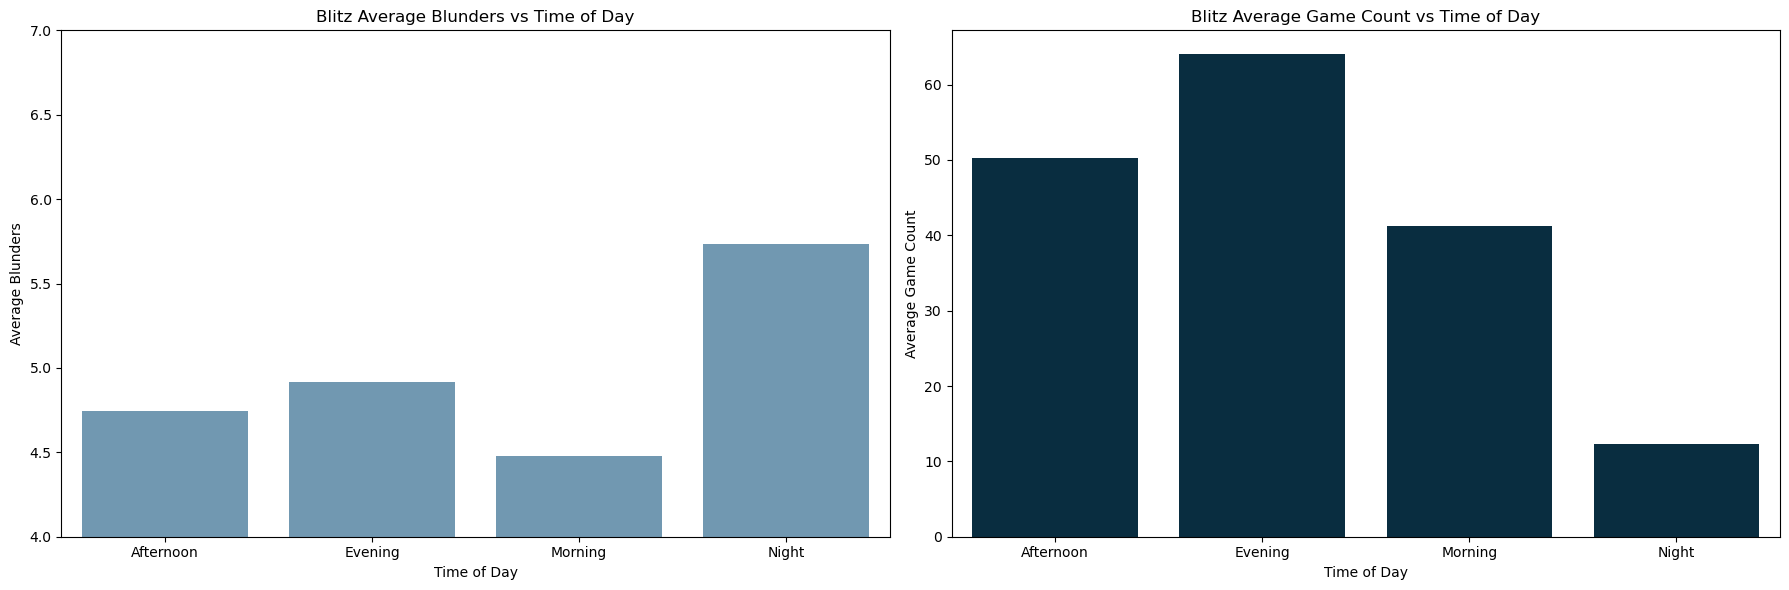

In [68]:
plot_avg_blunders_and_game_count(df, 'Blitz')

## Bullet Blunders vs Games Played According to Time of Day

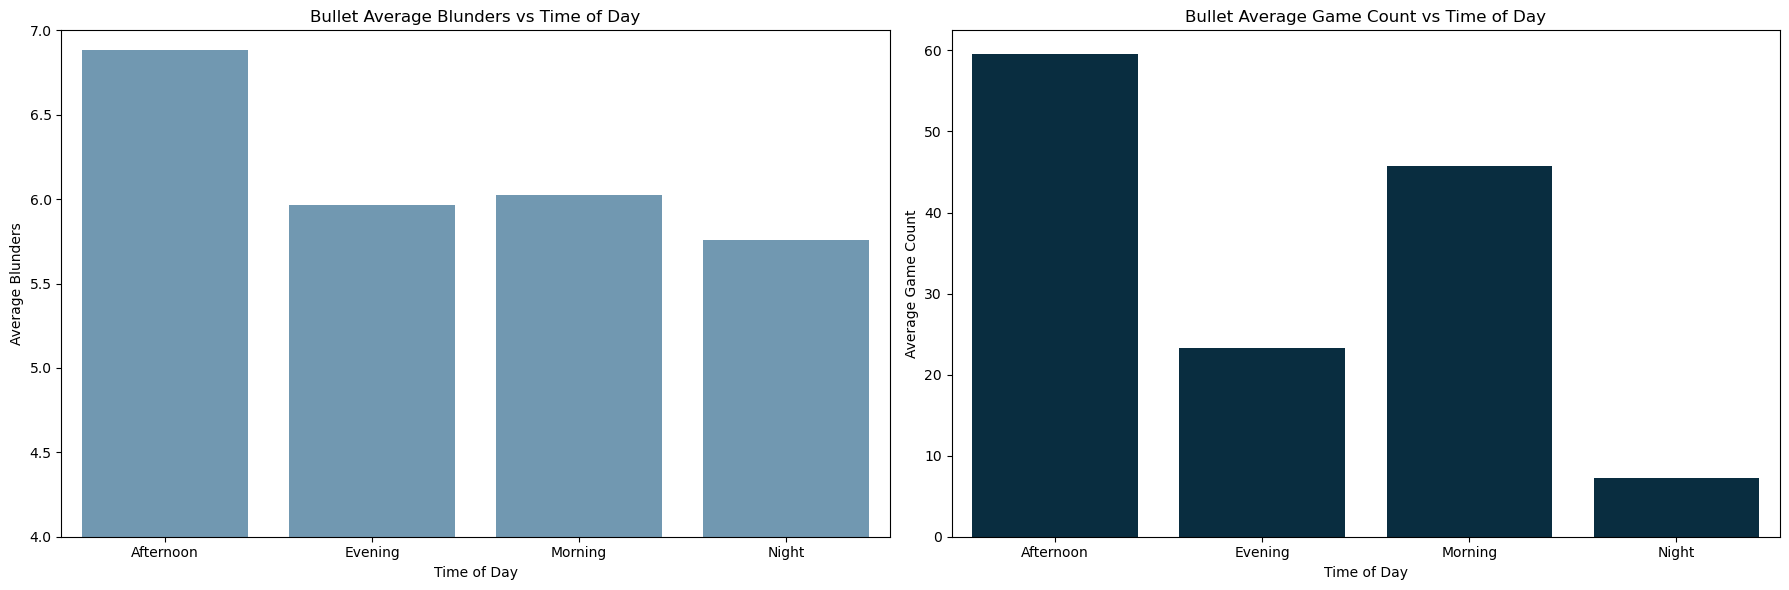

In [69]:
plot_avg_blunders_and_game_count(df, 'Bullet')

## How Much Does Elo Advantage Effect Winrate?

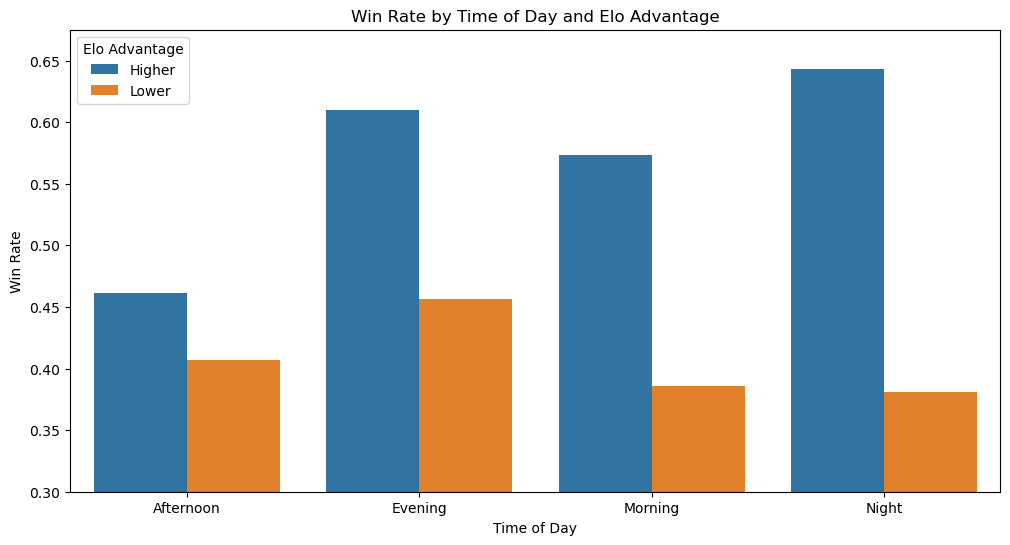

In [22]:
df['EloAdvantage'] = df.apply(lambda x: 'Higher' if int(x['MyElo']) > int(x['EnemyElo']) else 'Lower', axis=1)

win_rate_advantage = df.groupby(['TimeOfDay', 'EloAdvantage'])['Result'].apply(
    lambda x: (x == 'Win').sum() / len(x)
).reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='TimeOfDay', y='Result', hue='EloAdvantage', data=win_rate_advantage)
plt.title('Win Rate by Time of Day and Elo Advantage')
plt.ylabel('Win Rate')
plt.xlabel('Time of Day')
plt.legend(title='Elo Advantage')
plt.ylim(0.3)
plt.show()


## Comparison of Win Rate and Game Count by Hour

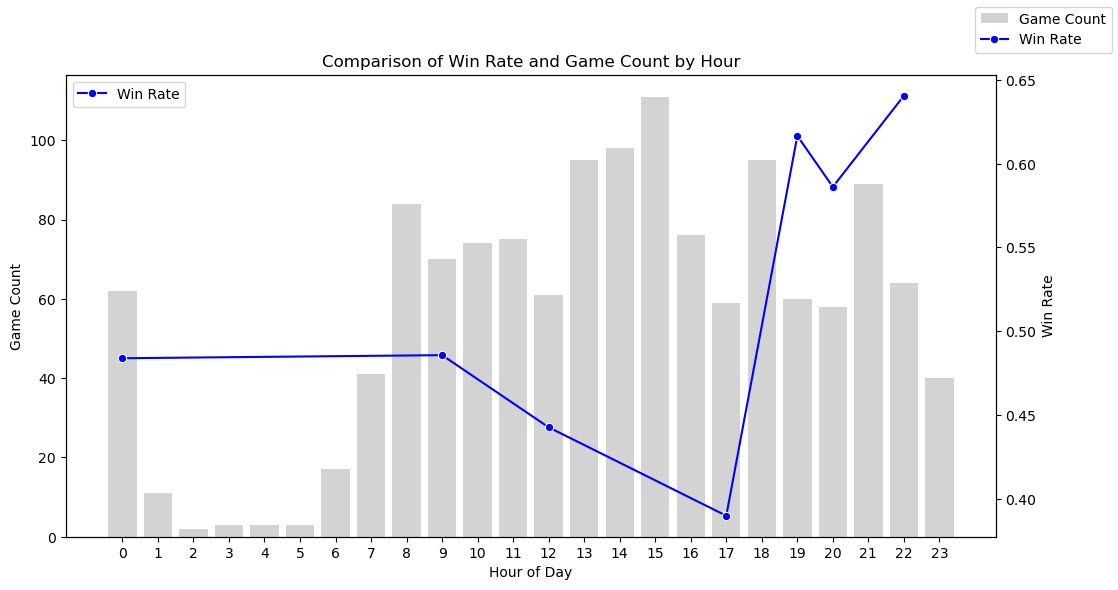

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def compare_similar_game_counts(df):
    # Count games by hour
    game_count_by_hour = df.groupby('Hour').size().reset_index(name='Game Count')
    
    median_game_count = game_count_by_hour['Game Count'].median()
    similar_hours = game_count_by_hour[
        game_count_by_hour['Game Count'].between(median_game_count * 0.8, median_game_count * 1.2)
    ]['Hour']
    
    df_similar_hours = df[df['Hour'].isin(similar_hours)]
    
    # Calculate win rates for those hours
    win_rate_by_hour = df_similar_hours.groupby('Hour')['Result'].apply(
        lambda x: (x == 'Win').sum() / len(x)
    ).reset_index(name='Win Rate')

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar plot for game count
    sns.barplot(x='Hour', y='Game Count', data=game_count_by_hour, ax=ax1, color='lightgrey', label='Game Count')
    ax1.set_ylabel('Game Count')
    ax1.set_xlabel('Hour of Day')
    
    # Line plot for win rate
    ax2 = ax1.twinx()
    sns.lineplot(x='Hour', y='Win Rate', data=win_rate_by_hour, ax=ax2, color='blue', marker='o', label='Win Rate')
    ax2.set_ylabel('Win Rate')

    fig.legend(loc='upper right')
    plt.title('Comparison of Win Rate and Game Count by Hour')
    plt.show()

compare_similar_game_counts(df)


In [13]:
#The line graph shows the win rate varying throughout the day. There is a noticeable dip in the win rate from 0 to 3 hours, after which it begins to rise and fluctuate. The win rate peaks around 19:00 (7 PM) and then again at 23:00 (11 PM).
#There is no clear consistent correlation between the number of games played and the win rate based on this graph. There are times, such as around 20:00, where a high game count coincides with a high win rate, but this is not a consistent pattern throughout the day.

## Comparison of Avg. Blunder and Game Count by Hour

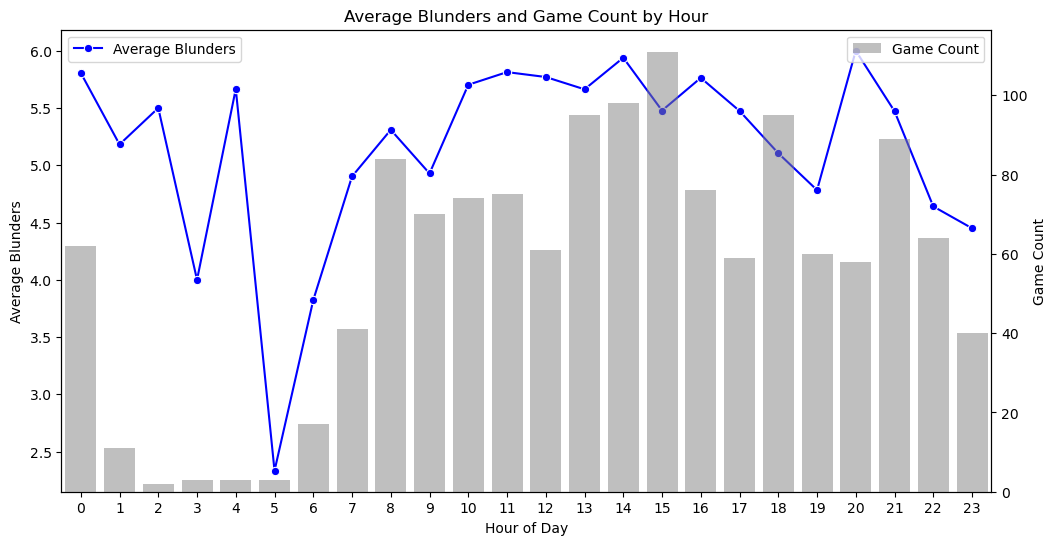

In [17]:


def plot_blunders_and_game_count(df):
    # Calculate average blunders by hour
    avg_blunders_by_hour = df.groupby('Hour')['Blunders'].mean().reset_index()

    # Count games by hour
    game_count_by_hour = df.groupby('Hour').size().reset_index(name='Game Count')

    # Create a figure with two subplots
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Average Blunders
    sns.lineplot(x='Hour', y='Blunders', data=avg_blunders_by_hour, marker='o', ax=ax1, color='blue', label='Average Blunders')
    ax1.set_ylabel('Average Blunders')
    ax1.set_xlabel('Hour of Day')
    ax1.legend(loc='upper left')

    # Plot Game Count on a secondary y-axis
    ax2 = ax1.twinx()
    sns.barplot(x='Hour', y='Game Count', data=game_count_by_hour, ax=ax2, alpha=0.5, color='grey', label='Game Count')
    ax2.set_ylabel('Game Count')
    ax2.legend(loc='upper right')

    plt.title('Average Blunders and Game Count by Hour')
    plt.show()

plot_blunders_and_game_count(df)


## Blitz vs Bullet Games Avarage Number of Moves Based on Time of The day

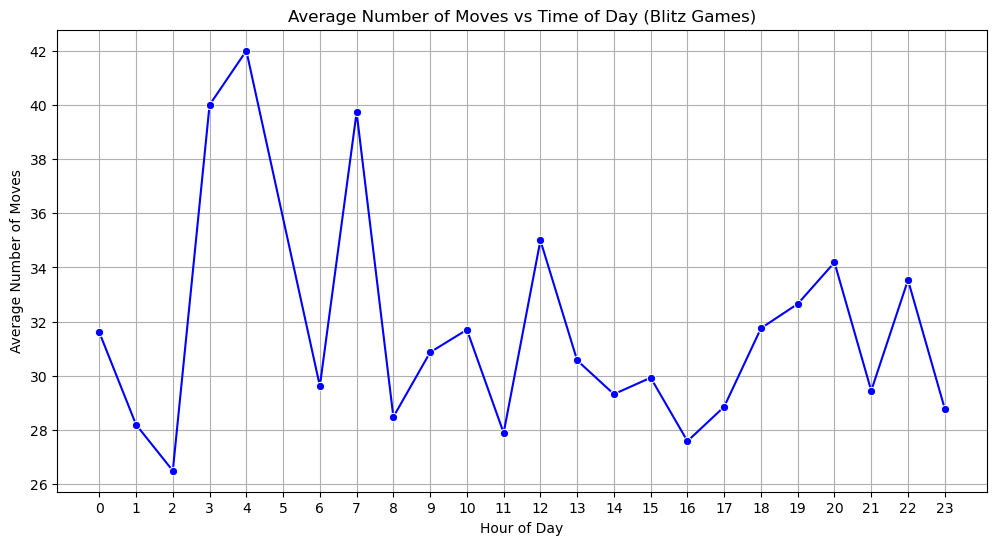

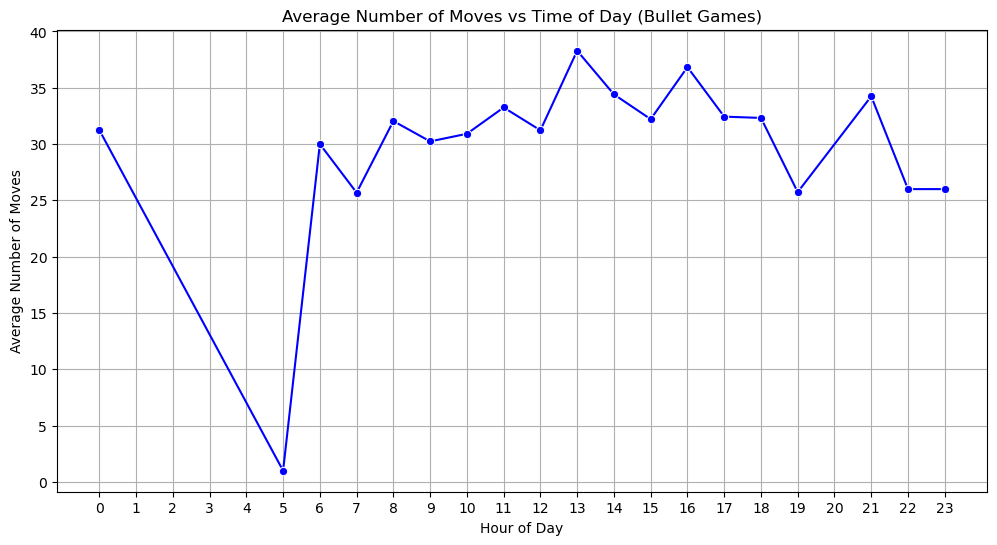

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_moves_vs_time(df, game_type='All'):

    if game_type != 'All':
        df = df[df['GameType'] == game_type]

    # Calculate the average number of moves made by hour
    avg_moves_data = df.groupby('Hour')['NumberOfMoves'].mean().reset_index()

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Hour', y='NumberOfMoves', data=avg_moves_data, marker='o', color='blue')
    plt.title(f'Average Number of Moves vs Time of Day ({game_type} Games)')
    plt.ylabel('Average Number of Moves')
    plt.xlabel('Hour of Day')
    plt.xticks(range(0, 24))  # Ensure all hours are shown
    plt.grid(True)
    plt.show()

plot_moves_vs_time(df_blitz, 'Blitz')
plot_moves_vs_time(df_bullet, 'Bullet')



## Observing Days of The Week

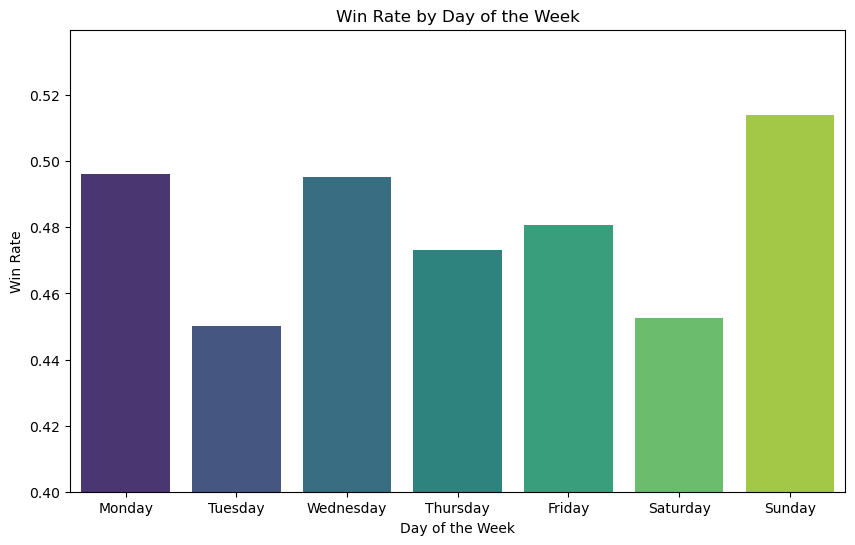

In [35]:

def plot_win_rate_by_day_of_week(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['DayOfWeek'] = df['Date'].dt.day_name()

    # Calculate win rate by day of the week
    win_rate_by_day = df.groupby('DayOfWeek')['Result'].apply(lambda x: (x == 'Win').sum() / len(x)).reset_index()

    # Order the days of the week starting from Monday
    order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    win_rate_by_day['DayOfWeek'] = pd.Categorical(win_rate_by_day['DayOfWeek'], categories=order, ordered=True)
    win_rate_by_day.sort_values('DayOfWeek', inplace=True)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='DayOfWeek', y='Result', data=win_rate_by_day, palette='viridis')
    plt.title('Win Rate by Day of the Week')
    plt.ylabel('Win Rate')
    plt.xlabel('Day of the Week')
    plt.ylim(0.4)
    plt.show()

plot_win_rate_by_day_of_week(df)

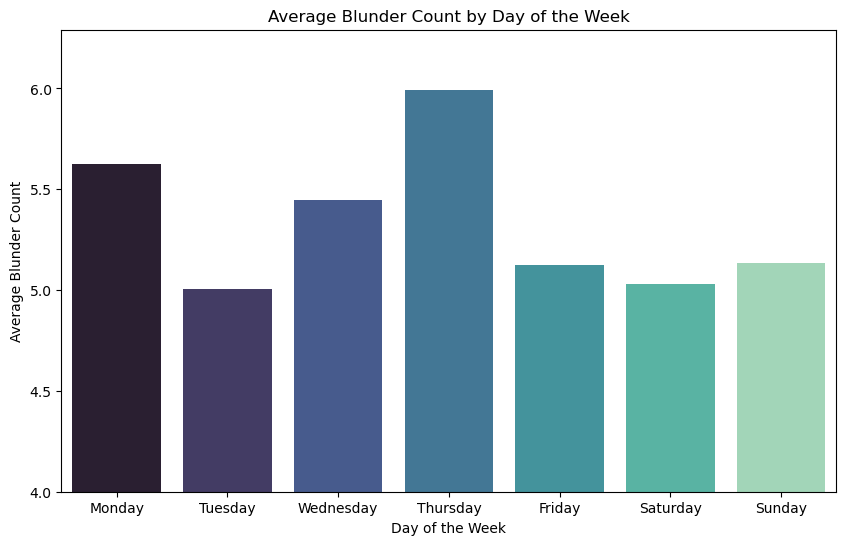

In [37]:


def plot_avg_blunders_by_day_of_week(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['DayOfWeek'] = df['Date'].dt.day_name()

    avg_blunders_by_day = df.groupby('DayOfWeek')['Blunders'].mean().reset_index()

    # Order the days of the week starting from Monday
    order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    avg_blunders_by_day['DayOfWeek'] = pd.Categorical(avg_blunders_by_day['DayOfWeek'], categories=order, ordered=True)
    avg_blunders_by_day.sort_values('DayOfWeek', inplace=True)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='DayOfWeek', y='Blunders', data=avg_blunders_by_day, palette='mako')
    plt.title('Average Blunder Count by Day of the Week')
    plt.ylabel('Average Blunder Count')
    plt.xlabel('Day of the Week')
    plt.ylim(4)
    plt.show()
    

plot_avg_blunders_by_day_of_week(df)
